In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

%pip install monai===0.7.0
%pip install segmentation-models-pytorch=0.2.0
%pip install gdown==3.6.4
%pip install segmentation_models_pytorch==0.2.0

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.
import os


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.2/650.2 kB 6.9 MB/s eta 0:00:00:00:010:01
Note: you may need to restart the kernel to use updated packages.
ERROR: Invalid requirement: 'segmentation-models-pytorch=0.2.0'
Hint: = is not a valid operator. Did you mean == ?
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... done
  Created wheel for gdown: filename=gdown-3.6.4-py3-none-any.whl size=6109 sha256=2848cfc007b266293f156429e08b6c523460b6503e1a7401e7c2e2c7c4d2101a
  Stored in directory: /root/.cache/pip/wheels/73/66/77/99342322fafc3a20e3a83cef3733f122d8a3d2d4be2fa61514
Successfully built gdown
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# import tarfile
# file = tarfile.open('../input/brats-2021-task1/BraTS2021_Training_Data.tar')

# file.extractall('./TrainingData')
# file.close()
import shutil
try:
    shutil.rmtree("/kaggle/working/TrainingData")
except FileNotFoundError:
    print("The directory does not exist.")
except OSError as e:
    print(f"Error: {e}")

# Segementation

In [ ]:
import os
import json

import logging
import pandas as pd 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


from monai.data import DataLoader, ImageDataset

from monai.transforms import (
    AddChannel,
    Compose,
    Resize,
    Transform
)


from sklearn.model_selection import GroupKFold

import torch.nn.functional as F

from multiprocessing import Pool


SETTINGS = {
    "DICOM_DATA_DIR":"/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification",
    "TASK1_DIR":"/kaggle/working/TrainingData", 
    "CLASSIFICATION_RAW_JPG":"/kaggle/input/miccaibraintumorjpgdata",
    "SEGMENT_DATA_DIR":"data/processed_segmentation_data", 
    "CLASSIFICATION_DATA_DIR":"data/processed_classification_data",
    "KFOLD_PATH":"/kaggle/input/sub-file-for-tumor/data/train_stratifiedgroupkfold.csv", 
    "SEGMENT_MODEL_DIR":"/kaggle/working/models/densenet121_2d_segment",
    "CLASSIFICATION_MODEL_DIR":"models/eca_nfnet_l0_2d_classification",
    "TEMP_DATA_DIR":"temp",
    "TEST_PREDICTION_FILE":"data/test_prediction.csv"
}

IM_FOLDER_TASK1 = SETTINGS['TASK1_DIR']

RUN_FOLDS = [0]
KFOLD_PATH = SETTINGS['KFOLD_PATH']

SEED = 67
N_PROCESSES = 4

OUT_FOLDER = SETTINGS['SEGMENT_DATA_DIR']

PLANES = ['sagital', 'coronal', 'axial']
MRI_TYPES = ['t1', 't1ce', 't2', 'flair']

import tarfile




# ============ Helper functions ===========
class ScaleRange(Transform):
    def __init__(self, new_max = 255.0):
        super(ScaleRange, self).__init__()
        self.new_max = new_max
        
    def __call__(self, data):
        dmin, dmax = data.min(), data.max()
        return (data - dmin) / (dmax-dmin) * self.new_max

class ConvertToMultiChannelBasedOnBratsClasses(Transform):
    """
    Convert labels to multi channels based on brats classes:
    label 2 is the peritumoral edema
    label 4 is the GD-enhancing tumor
    label 1 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).
    Ehancing Tumor (ET) = enhancing tumor
    Tumor Core (TC) = enhancing tumor + necrotic
    Whole Tumor (WT) = enhancing tumor + necrotic + edema    
    """

    def __call__(self, masks):
        '''This time we only use 2 label: 0 - WT and 1 - ET'''
        result = []

        # merge labels 1, 2 and 4 to construct WT
        result.append(
            np.logical_or(
                np.logical_or(masks == 1, masks == 2), masks == 4
            )
        )
        # label 4 is ET
        result.append(masks == 4)
        
        return np.stack(result, axis=0).astype(np.float32)

def get_non_0_voxels_and_masks(voxels, masks_2channels, ax=0, min_avg=0.01):
    '''Get non-empty slices from the 3D mask
        A 2D slice is considered to be empty if its mean pixel value < min_avg'''
    masks = np.logical_or(masks_2channels[0], masks_2channels[1])
    remain_axes = tuple([i for i in range(len(voxels.shape)) if i != ax])
    ax_mean = masks.mean(axis=remain_axes)
    ax_non_0_inds = ax_mean > min_avg
    if(ax==0):
        return voxels[ax_non_0_inds], masks_2channels[:, ax_non_0_inds, :, :]
    if(ax==1):
        return voxels[:,ax_non_0_inds,:], masks_2channels[:, :, ax_non_0_inds,:]
    if(ax==2):
        return voxels[:,:,ax_non_0_inds], masks_2channels[:,:,:,ax_non_0_inds]
    
def sampling_slices(non_0_voxels, non_0_masks, ax=0, keep_rate=0.1):
    '''Nearby slices are similar to each other, we use sample to only get the different ones'''
    total_slices = non_0_voxels.shape[ax]
    T = max(round(total_slices * keep_rate), 1)
    sampling_inds = np.arange(0, total_slices, T)
    
    if(ax==0):
        return non_0_voxels[sampling_inds], non_0_masks[:, sampling_inds, :, :]
    if(ax==1):
        return non_0_voxels[:, sampling_inds, :], non_0_masks[:, :, sampling_inds, :]
    if(ax==2):
        return non_0_voxels[:, :, sampling_inds], non_0_masks[:, :, :, sampling_inds]
    
    
def process_one_patient(voxels, masks, patient_id):
    '''Perform slicing 2D images and tumor masks for this patient'''
    current_list_patient_id = []
    current_list_plane = []
    current_list_mri_type = []
    current_list_slice_index = []
    current_list_file_path = []
    current_list_segfile_path = []
    
    for ax, plane in enumerate(PLANES):
        non_0_voxels, non_0_masks = get_non_0_voxels_and_masks(voxels, masks, ax=ax)
        if(non_0_voxels.shape[ax]==0):
            print(f'Cannot get any slice in patient: {patient_id}, plane: {plane} due to the masks are too small')
            continue
        sampled_non_0_voxels, sampled_non_0_masks = sampling_slices(non_0_voxels, non_0_masks, ax=ax)

        for j in range(sampled_non_0_voxels.shape[ax]):
            file_path = os.path.join(OUT_FOLDER + '/2D_slice_data/', 
                                     f'BraTS2021_{patient_id:05d}',
                                     f'BraTS2021_{patient_id:05d}_{mri_type}',
                                    f'BraTS2021_{patient_id:05d}_{mri_type}_{plane}_{j:03d}')
            seg_file_path = os.path.join(OUT_FOLDER + '/2D_slice_data/', 
                                     f'BraTS2021_{patient_id:05d}',
                                    f'BraTS2021_{patient_id:05d}_segmask',
                                    f'BraTS2021_{patient_id:05d}_segmask_{plane}_{j:03d}')

            os.makedirs(os.path.dirname(file_path), exist_ok=True)
            os.makedirs(os.path.dirname(seg_file_path), exist_ok=True)
            
            if(ax==0):
                np.save(file_path, sampled_non_0_voxels[j])
                np.save(seg_file_path, sampled_non_0_masks[:,j])
            elif(ax==1):
                np.save(file_path, sampled_non_0_voxels[:,j,:])
                np.save(seg_file_path, sampled_non_0_masks[:,:,j,:])
            elif(ax==2):
                np.save(file_path, sampled_non_0_voxels[:,:,j])
                np.save(seg_file_path, sampled_non_0_masks[:,:,:,j])
            else:
                raise ValueError('No such ax')

            current_list_patient_id.append(patient_id)
            current_list_plane.append(plane)
            current_list_mri_type.append(mri_type)
            current_list_slice_index.append(j)
            current_list_file_path.append(file_path)
            current_list_segfile_path.append(seg_file_path)

    return current_list_patient_id, current_list_plane, current_list_mri_type,  \
            current_list_slice_index, current_list_file_path, current_list_segfile_path


def update(args):
    global list_patient_id, list_plane, list_mri_type, list_slice_index, list_file_path, list_segfile_path
    pbar.update()
    current_list_patient_id, current_list_plane, current_list_mri_type,  \
            current_list_slice_index, current_list_file_path, current_list_segfile_path = args
    
    list_patient_id += current_list_patient_id
    list_plane += current_list_plane
    list_mri_type += current_list_mri_type
    list_slice_index += current_list_slice_index
    list_file_path += current_list_file_path
    list_segfile_path += current_list_segfile_path


def error(e):
    print(e)
        
# =========================================

# ============ Read meta data =============
fold_df = pd.read_csv(KFOLD_PATH)
fold_df['pfolder'] = fold_df.BraTS21ID.map(lambda x: f'BraTS2021_{x:05d}')

PATIENT_DIRS = []
for p in os.listdir(IM_FOLDER_TASK1):
    try:
       
        int(p.split('_')[-1])
        PATIENT_DIRS.append(p)
    except:
        print('Non patient dir:', p)

df = pd.DataFrame(PATIENT_DIRS, columns=['pfolder'])


df['BraTS21ID'] = df['pfolder'].map(lambda x: int(x.split('_')[-1]))
df = df.dropna()

df = df[~df.BraTS21ID.isin(fold_df.BraTS21ID.tolist())]

for t in MRI_TYPES:
    df[f'{t}_data_path'] = df.pfolder.map(lambda x: os.path.join(IM_FOLDER_TASK1, x, x+f'_{t}.nii.gz'))
df['seg_label_path'] = df.pfolder.map(lambda x: os.path.join(IM_FOLDER_TASK1, x, x+f'_seg.nii.gz'))

# =========================================


# ============ Create a nii gz file loader ==========
transforms = Compose([ScaleRange()])

seg_transforms = Compose([ConvertToMultiChannelBasedOnBratsClasses(),
                         ])

mri_type = MRI_TYPES[0]
# Define nifti dataset, data loader
dataset = ImageDataset(image_files=df[f'{mri_type}_data_path'].tolist(),
                             seg_files = df.seg_label_path.tolist(),
                             seg_transform=seg_transforms,
                            transform=transforms
                      )
# =====================================================



# ========== Perform slicing data and mask ============

for mri_type in MRI_TYPES:
    dataset = ImageDataset(image_files=df[f'{mri_type}_data_path'].tolist(),
                                 seg_files = df.seg_label_path.tolist(),
                                   labels = df['BraTS21ID'].tolist(),
                                 seg_transform=seg_transforms,
                                transform=transforms
                          )
    
    os.makedirs(OUT_FOLDER + '/2D_slice_data/', exist_ok=True)

    list_patient_id = []
    list_plane = []
    list_mri_type = []
    list_slice_index = []
    list_file_path = []
    list_segfile_path = []

    pool = Pool(processes=N_PROCESSES)   

    iterations = range(len(dataset))
    pbar = tqdm(iterations)

    for i in iterations:
        voxels, masks, patient_id = dataset[i]
        pool.apply_async(
            process_one_patient,
            args=(voxels, masks, patient_id),
            callback=update,
            error_callback=error,
        )

    pool.close()
    pool.join()
    pbar.close()
    
out_df = pd.DataFrame({
    'BraTS21ID':list_patient_id,
    'mri_type':list_mri_type,
    'plane':list_plane,
    'slice_index':list_slice_index,
    'file_path':list_file_path,
    'segfile_path':list_segfile_path
})

out_df.to_csv(os.path.join(OUT_FOLDER, 'segment_meta.csv'))
# =====================================================


# ================= Kfold split ====================
kfold = GroupKFold(n_splits=5)

i = 0
for train_ind, valid_ind in kfold.split(out_df,out_df,out_df['BraTS21ID']):
    out_df.loc[valid_ind, 'fold'] = i
    i+=1
out_df.to_csv(f'{OUT_FOLDER}/segment_meta_groupkfold.csv', index=False)
# ==================================================
    
    
  

(2, 240, 240)
(240, 240)


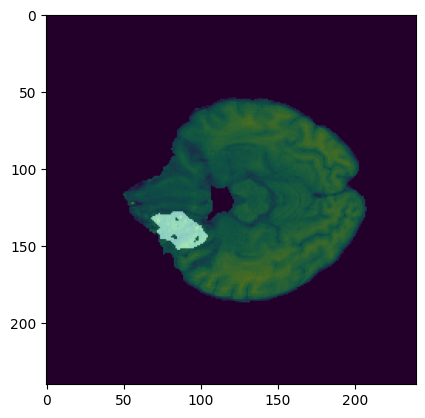

In [31]:
import numpy as np
import matplotlib.pyplot as plt

img=np.load("/kaggle/input/processed-segementation/processed_segmentation_data/2D_slice_data/BraTS2021_00000/BraTS2021_00000_segmask/BraTS2021_00000_segmask_axial_000.npy")
mask=np.load("/kaggle/input/processed-segementation/processed_segmentation_data/2D_slice_data/BraTS2021_00000/BraTS2021_00000_t1/BraTS2021_00000_t1_axial_000.npy")
print(img.shape)
print(mask.shape)

plt.figure()
plt.imshow(mask)
plt.imshow(img[1,:,:], cmap="gray", alpha=0.5)



# Models

In [ ]:
import gdown
import os

# os.makedirs('pretrained_models', exist_ok=True)
# url = 'https://drive.google.com/uc?id=14dmJ2HEEsdDzcsbJC_qTAQPxOGSSkDY3'
# output = 'pretrained_models/eca_nfnet_l0.pth'
# gdown.download(url, output, quiet=False)

# os.makedirs('pretrained_models', exist_ok=True)
# url = 'https://drive.google.com/uc?id=1hV4HECWeiHpFkBTES2nYPpnlYM0dApRJ'
# output = 'pretrained_models/unet_pp_densenet121_2channels_out.pth'
# gdown.download(url, output, quiet=False)

# os.makedirs('models/densenet121_2d_segment', exist_ok=True)
# url = 'https://drive.google.com/uc?id=12EVeyHI_kQlryAp6554Au4S1pt1ektnY'
# output = 'models/densenet121_2d_segment/Fold0_densenet121_2d_segment.pth'
# gdown.download(url, output, quiet=False)

# os.makedirs('models/eca_nfnet_l0_2d_classification/T1w', exist_ok=True)
# url = 'https://drive.google.com/uc?id=1wFJAurtdm8_G-nV2DVUQlWy7X4h4lBjo'
# output = 'models/eca_nfnet_l0_2d_classification/T1w/T1w_Fold0_eca_nfnet_l0_2d_classification.pth'
# gdown.download(url, output, quiet=False)

# os.makedirs('models/eca_nfnet_l0_2d_classification/T1wCE', exist_ok=True)
# url = 'https://drive.google.com/uc?id=1fmMScOnUyDWNDEYewtX7CpDMz6EFr3Vd'
# output = 'models/eca_nfnet_l0_2d_classification/T1wCE/T1wCE_Fold0_eca_nfnet_l0_2d_classification.pth'
# gdown.download(url, output, quiet=False)

# os.makedirs('models/eca_nfnet_l0_2d_classification/T2w', exist_ok=True)
# url = 'https://drive.google.com/uc?id=1JPAcR2vCDtvblDqPljx_poZNUTC00OET'
# output = 'models/eca_nfnet_l0_2d_classification/T2w/T2w_Fold0_eca_nfnet_l0_2d_classification.pth'
# gdown.download(url, output, quiet=False)

# os.makedirs('models/eca_nfnet_l0_2d_classification/FLAIR', exist_ok=True)
# url = 'https://drive.google.com/uc?id=12UBvr4ewswPWzf-8OyM4GjqYugonlTjY'
# output = 'models/eca_nfnet_l0_2d_classification/FLAIR/FLAIR_Fold0_eca_nfnet_l0_2d_classification.pth'
# gdown.download(url, output, quiet=False)


# Utility

In [ ]:
import pandas as pd
import numpy as np
import json
import re
import torch
import random
import sys
import os
import matplotlib.pyplot as plt
import logging

from tqdm import tqdm
from copy import deepcopy
from typing import List

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def get_logger(name, path, mode='a'):
    logger = logging.getLogger(name)  

    if not logger.hasHandlers():
        # set log level
        logger.setLevel(logging.INFO)

        # define file handler and set formatter
        file_handler = logging.FileHandler(path, mode=mode)
        formatter    = logging.Formatter('%(asctime)s : %(levelname)s : %(name)s : %(message)s')
        file_handler.setFormatter(formatter)

        # add file handler to logger
        logger.addHandler(file_handler)
    
    return logger
    
    
def log_and_print(logger, obj):
    print(obj)
    logger.info(obj)    
    
def init_progress_dict(metrics):
    progress_dict = dict()
    for metric in metrics:
        progress_dict[f'train_{metric}'] = []
        progress_dict[f'valid_{metric}'] = []
    return progress_dict

def log_to_progress_dict(progress_dict, metric_dict):
    for k, v in metric_dict.items():
        progress_dict[k].append(v)
       
    return progress_dict

def save_progress(progress_dict, out_folder, out_folder_name, fold, show=False):
    metric_names = list(progress_dict.keys())
    epochs = len(progress_dict[metric_names[0]])+1
    
    # plot figure and save the progress chart
    n_cols = 4
    n_rows = int(np.ceil(len(metric_names) / 2 / n_cols))
    
    plt.figure(figsize=(7*n_cols, 7*n_rows))
    
    for i in range(0, len(metric_names), 2):
        plt.subplot(n_rows,n_cols,int(i/2+1))

        plt.plot(range(1, epochs), progress_dict[metric_names[i]])
        plt.plot(range(1, epochs), progress_dict[metric_names[i+1]])
        plt.legend([metric_names[i], metric_names[i+1]])
        plt.xlabel('Epoch')
        plt.title(f'{metric_names[i]} and {metric_names[i+1]}')

    save_name = f'training_progress_{out_folder_name}_fold{fold}'
    plt.savefig(os.path.join(out_folder, save_name+'.jpg'))

    if(show):
        plt.show()

    pd.DataFrame({'epoch':range(1, epochs), **progress_dict}).to_csv(os.path.join(out_folder, save_name+'.csv'), index=False)

    
def check_mem(cuda_device):
    devices_info = os.popen('"/usr/bin/nvidia-smi" --query-gpu=memory.total,memory.used --format=csv,nounits,noheader').read().strip().split("\n")
    total, used = devices_info[int(cuda_device)].split(',')
    return total,used

def occumpy_mem(cuda_device):
    total, used = check_mem(cuda_device)
    total = int(total)
    used = int(used)
    max_mem = int(total * 0.9)
    block_mem = max_mem - used
    x = torch.cuda.FloatTensor(256,1024,block_mem)
    del x

# Training

In [80]:

import os
import logging
import pandas as pd 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
from torch import nn

from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, CosineAnnealingLR

import torch.nn.functional as F

import json
import gc
from sklearn.metrics import roc_auc_score, accuracy_score

from segmentation_models_pytorch.unetplusplus.model import UnetPlusPlus
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import argparse

# parser = argparse.ArgumentParser(description='Insert some arguments')
# parser.add_argument('--gpu', type=int,
#                     help='GPU ID', default=0)
# parser.add_argument('--batch_size', type=int,
#                     help='Batch size', default=128)
# parser.add_argument('--n_workers', type=int,
#                     help='Number of parrallel workers', default=8)
# args = parser.parse_args()
argv = sys.argv[1:]  # Exclude the first argument (script name)
if '-f' in argv:
    argv = argv[:argv.index('-f')]  # Ignore everything after '-f'

# Set up the parser
parser = argparse.ArgumentParser(description='Insert some arguments')
parser.add_argument('--gpu', type=int, help='GPU ID', default=0)
parser.add_argument('--batch_size', type=int, help='Batch size', default=128)
parser.add_argument('--n_workers', type=int, help='Number of parallel workers', default=8)

# Parse the cleaned arguments
args = parser.parse_args(argv)


# with open('SETTINGS.json', 'r') as f:
SETTINGS = {
    "DICOM_DATA_DIR":"/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification",
    "TASK1_DIR":"/kaggle/working/TrainingData", 
    "CLASSIFICATION_RAW_JPG":"/kaggle/input/miccaibraintumorjpgdata",
    "SEGMENT_DATA_DIR":"/kaggle/input/segmentaed-csv", 
    "CLASSIFICATION_DATA_DIR":"data/processed_classification_data",
    "KFOLD_PATH":"/kaggle/input/sub-file-for-tumor/data/train_stratifiedgroupkfold.csv", 
    "SEGMENT_MODEL_DIR":"/kaggle/working/models/densenet121_2d_segment",
    "CLASSIFICATION_MODEL_DIR":"models/eca_nfnet_l0_2d_classification",
    "TEMP_DATA_DIR":"temp",
    "TEST_PREDICTION_FILE":"data/test_prediction.csv"
        }

FOLDER = SETTINGS['SEGMENT_DATA_DIR']
META_FILE_PATH = os.path.join(SETTINGS['SEGMENT_DATA_DIR'], 'segment_meta_groupkfold.csv')

RUN_FOLDS = [0]
SEED = 67
DIM = (224, 224, 3)
# N_WORKERS = args.n_workers
BATCH_SIZE = 32
BASE_LR = 1e-4
NUM_EPOCHS = 30
PATIENT = 10
SAMPLE = None
DEVICE = torch.device(f'cuda:{args.gpu}')

PARENT_OUT_FOLDER = f'models/'    

CANDIDATES = [
    {
        'backbone_name':'densenet121',
        'ver_note':'2d_segment',
        'backbone_pretrained':f'/kaggle/input/pretranied_models/tensorflow2/default/1/unet_pp_densenet121_2channels_out (1).pth',
        'batch_size':BATCH_SIZE,
        'warm_up_epochs':5,
    },
]

import sys
# from utils.general import seed_torch, init_progress_dict, log_to_progress_dict, save_progress, log_and_print, get_logger

# seed every thing
seed_torch(SEED)

# ================= Some helper functions ====================
class BrainSegment2DDataset(torch.utils.data.Dataset):
    
    def __init__(self, csv, transforms=None):
        self.csv = csv.reset_index(drop=True)
        self.augmentations = transforms

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        image = np.load(row['file_path']+'.npy')
        image = np.stack([image]*3, axis=-1)
        mask = np.load(row['segfile_path']+'.npy')
        mask = np.stack([mask[0], mask[1]], axis=-1)
        
        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            mask = mask.permute(2,0,1)
        
        return image, mask
    

def get_train_transforms(candidate):
    dim = candidate.get('dim', DIM)
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
     
            A.Resize(width=dim[1], height=dim[0], always_apply=True),
            A.Normalize(),
            ToTensorV2(p=1.0)
        ]
    )

def get_valid_transforms(candidate):
    dim = candidate.get('dim', DIM)
    return A.Compose(
        [
            A.Resize(width=dim[1], height=dim[0], always_apply=True),
            A.Normalize(),
            ToTensorV2(p=1.0)
        ]
    )

def get_model(candidate):
    model = UnetPlusPlus(
        encoder_name = candidate['backbone_name'],
        encoder_depth = 5,
        encoder_weights = None,
        classes = 2,
        activation = 'sigmoid',
    )

    weight_path = candidate.get('backbone_pretrained')
    if(weight_path is not None):
        print('Load pretrained:', weight_path)
        model.load_state_dict(torch.load(weight_path, map_location='cpu'))
        
    return model


class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def train_valid_fn(dataloader,model,criterion,iou_metric,optimizer=None,device='cuda:0',
                            scheduler=None,epoch=0, mode='train', scaler=None):
    '''Perform model training'''
    if(mode=='train'):
        model.train()
    elif(mode=='valid'):
        model.eval()
    else:
        raise ValueError('No such mode')
        
    loss_score = AverageMeter()
    iou_score = AverageMeter()
    
    tk0 = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, batch in tk0:
        if(mode=='train'):
            optimizer.zero_grad()
            
        # input, gt
        images, gt_masks = batch
        images = images.to(DEVICE)
        gt_masks = gt_masks.to(DEVICE)

        with torch.cuda.amp.autocast():
            # prediction
            pred_masks = model(images)

            # compute loss
            loss = criterion(y_true=gt_masks, y_pred=pred_masks)
            
            # compute metric
            iou = iou_metric(pred_masks, gt_masks)
        
        if(mode=='train'):
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        loss_score.update(loss.detach().cpu().item(), dataloader.batch_size)
        iou_score.update(iou.detach().cpu().item(), dataloader.batch_size)
        
        if(mode=='train'):
            tk0.set_postfix(Loss_Train=loss_score.avg, IOU_Train=iou_score.avg, 
                            Epoch=epoch, LR=optimizer.param_groups[0]['lr'])
        elif(mode=='valid'):
            tk0.set_postfix(Loss_Valid=loss_score.avg, IOU_Valid=iou_score.avg, Epoch=epoch)
        
        del batch, images, gt_masks, pred_masks, loss, iou
        torch.cuda.empty_cache()
        
    if(mode=='train'):
        if(scheduler.__class__.__name__ == 'CosineAnnealingWarmRestarts'):
            scheduler.step(epoch=epoch)
        elif(scheduler.__class__.__name__ == 'ReduceLROnPlateau'):
            scheduler.step(loss_score.avg)
    
    return loss_score.avg, iou_score.avg

def dfs_freeze(module):
    for name, child in module.named_children():
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)
        
def dfs_unfreeze(module):
    for name, child in module.named_children():
        for param in child.parameters():
            param.requires_grad = True
        dfs_unfreeze(child)
# ===========================================================
  
# ===========================================================
        
    
# ================ Read metadata =================
df = pd.read_csv(META_FILE_PATH)
# ================================================


# ============================ Training ==============================
for candidate in CANDIDATES:
    print(f"######################### Candidate: {candidate['backbone_name']} ############################")
    run_folds = candidate.get('run_folds', RUN_FOLDS)
    
    parent_out_folder = candidate.get('parent_out_folder', PARENT_OUT_FOLDER)
    ver_note = candidate['ver_note']
    out_folder_name = f"{candidate['backbone_name']}_{ver_note}"
    out_folder = os.path.join(parent_out_folder, out_folder_name)

    os.makedirs(out_folder, exist_ok=True)
    
    for valid_fold in run_folds:
        # Read data
        if(SAMPLE):
            df = df.sample(SAMPLE, random_state=SEED)

        train_df = df[df.fold!=valid_fold]
        valid_df = df[df.fold==valid_fold]

        print(f'\n\n================= Fold {valid_fold} ==================')
        print(f'Number of training images: {len(train_df)}. Number of valid images: {len(valid_df)}')
#         print("filepath",traindf)
        
        train_dataset = BrainSegment2DDataset(train_df, get_train_transforms(candidate))
        valid_dataset = BrainSegment2DDataset(train_df, get_valid_transforms(candidate))
        
        batch_size = candidate.get('batch_size', BATCH_SIZE)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        
        # model
        model = get_model(candidate)
        # freeze layer
        dfs_freeze(model.encoder)
        print(' -------- Start warm up process ----------')
        print('Freeze encoder')
        model.to(DEVICE)
        print()
        
        # Optimizer and scheduler
        base_lr = candidate.get('base_lr', BASE_LR)
        optim = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=BASE_LR)

        num_training_steps = NUM_EPOCHS * len(train_loader)
        lr_scheduler = ReduceLROnPlateau(optimizer=optim)

        # loss
        criterion = DiceLoss(mode='binary', from_logits=False)
        iou_metric = IoU()

        # use amp to accelerate training
        scaler = torch.cuda.amp.GradScaler()

        # Logging
        logger = get_logger(
            name = f'training_log_fold{valid_fold}.txt',
            path=os.path.join(out_folder, f'training_log_fold{valid_fold}.txt')
        )

        best_valid_loss = 9999
        best_valid_ep = 0
        patient = PATIENT

        progress_dict = init_progress_dict(['loss', 'IOU'])

        start_ep = candidate.get('warm_start_ep', 1)
        print('Start ep:', start_ep)

        # warm up epochs
        warm_up_epochs = candidate.get('warm_up_epochs', 1)

        
        for epoch in range(start_ep, NUM_EPOCHS+1):
            if (epoch==warm_up_epochs+1):
                print(' -------- Finish warm up process ----------')
                print('Unfreeze encoder')
                dfs_unfreeze(model.encoder)
                optim = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=BASE_LR)
                lr_scheduler = ReduceLROnPlateau(optimizer=optim)
                
            # =============== Training ==============
            train_loss, train_iou = train_valid_fn(train_loader,model, criterion, iou_metric,
                                                    optimizer=optim,device=DEVICE,
                                                    scheduler=lr_scheduler,epoch=epoch,mode='train',
                                                  scaler=scaler)
            valid_loss, valid_iou = train_valid_fn(valid_loader,model, criterion, iou_metric,
                                                     device=DEVICE, 
                                                     epoch=epoch,mode='valid',
                                                  scaler=scaler)

            current_lr = optim.param_groups[0]['lr']
            log_line = f'Model: {out_folder_name}. Epoch: {epoch}. '
            log_line += f'Train loss:{train_loss} - Valid loss: {valid_loss}. '
            log_line += f'Train IOU:{train_iou} - Valid IOU: {valid_iou}. '
            log_line += f'Lr: {current_lr}.'

            log_and_print(logger, log_line)

            metric_dict = {'train_loss':train_loss,'valid_loss':valid_loss,
                           'train_IOU':train_iou, 'valid_IOU':valid_iou,
                       }

            progress_dict = log_to_progress_dict(progress_dict, metric_dict)

            # plot figure and save the progress chart
            save_progress(progress_dict, out_folder, out_folder_name, valid_fold, show=False)

            if(valid_loss < best_valid_loss):
                best_valid_loss = valid_loss
                best_valid_ep = epoch
                patient = PATIENT # reset patient

                # save model
                name = os.path.join(out_folder, 'Fold%d_%s.pth'%(valid_fold, 
                                                                 out_folder_name, 
                                                                ))
                log_and_print(logger, 'Saving model to: ' + name)
                torch.save(model.state_dict(), name)
            else:
                patient -= 1
                log_and_print(logger, 'Decrease early-stopping patient by 1 due valid loss not decreasing. Patient='+ str(patient))

            if(patient == 0):
                log_and_print(logger, 'Early stopping patient = 0. Early stop')
                break

# ======================================================================




/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


NameError: name 'sys' is not defined

# Load Model and Predict

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp



densenet_121 = smp.UnetPlusPlus(
    encoder_name="densenet121",  # Encoder backbone
    encoder_weights=None,        # No pre-trained encoder weights
    in_channels=3,               # Number of input channels (e.g., grayscale MRI)
    classes=2                    # Number of output classes (e.g., tumor and background)
)

# Load the pre-trained PyTorch model
state_dict= torch.load("/kaggle/input/pretranied_models/tensorflow2/default/1/unet_pp_densenet121_2channels_out (1).pth")

densenet_121.load_state_dict(state_dict)

densenet_121.eval()  # Set the model to evaluation mode


# # Load the MRI slice from .npy file
# npy_path = "/kaggle/input/processed-segementation/processed_segmentation_data/2D_slice_data/BraTS2021_00000/BraTS2021_00000_segmask/BraTS2021_00000_segmask_axial_000.npy"
# mri_slice = np.load(npy_path)  # Load the NumPy array

# # Ensure the input has the correct shape (batch_size, channels, height, width)
# # Assuming the MRI slice has shape (H, W), add batch and channel dimensions
# input_tensor = torch.tensor(mri_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
# # Make prediction
# with torch.no_grad():  # Disable gradients for inference
#     output = densenet_121(input_tensor)

# # Output the prediction
# print(f'Prediction shape: {output.shape}')
# print(f'Prediction: {output}')


In [102]:
import torch
import torch.nn.functional as F
# dsvfa


# Load the MRI slice from .npy file (assumed to contain 2 slices)
npy_path = "/kaggle/input/processed-segementation/processed_segmentation_data/2D_slice_data/BraTS2021_00000/BraTS2021_00000_segmask/BraTS2021_00000_segmask_axial_000.npy"
mri_slices = np.load(npy_path)  # Shape: (2, 240, 240)
mri_slices.shape

# Process each slice separately
# for i in range(mri_slices.shape[0]):
single_slice = mri_slices[0] # Select one slice (shape: 240x240)

    # Prepare input tensor: (batch_size=1, channels=1, height=240, width=240)
input_tensor = torch.tensor(single_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
input_tensor = input_tensor.repeat(1, 3, 1, 1)
input_tensor.shape
    # Make prediction
with torch.no_grad():
        output = densenet_121(input_tensor)

print(f'Slice {i} prediction shape: {output.shape}')
print(f'Prediction: {output}')
output = F.interpolate(output, size=(240,240), mode='bicubic', align_corners=True)

for i in range(output.shape[1]):  # Loop through number of classes
    plt.figure()
    plt.imshow(output[0, i, :, :] )# First output, i-th class
    plt.title(f'Class {i}')
#     plt.axis('off')
    plt.show()

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 14 but got size 15 for tensor number 1 in the list.

In [99]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load the MRI slice from .npy file (assumed to contain 2 slices)
npy_path = "/kaggle/input/processed-segementation/processed_segmentation_data/2D_slice_data/BraTS2021_00000/BraTS2021_00000_segmask/BraTS2021_00000_segmask_axial_000.npy"
mri_slices = np.load(npy_path)  # Shape: (2, 240, 240)

# Select one slice (shape: 240x240)
single_slice = mri_slices[0]

# Prepare input tensor: (batch_size=1, channels=1, height=240, width=240)
input_tensor = torch.tensor(single_slice, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 1, 240, 240)
input_tensor = input_tensor.repeat( 3, 1, 1)  # Repeat to have 3 channels: (1, 3, 240, 240)

# Make prediction
with torch.no_grad():
    output = densenet_121(input_tensor)  # Assuming densenet_121 is defined and loaded

# Assuming output shape: (1, num_classes, height, width)
print(f'Slice prediction shape: {output.shape}')
print(f'Prediction: {output}')

# Upsample the output to match the original size
output = F.interpolate(output, size=(240, 240), mode='bicubic', align_corners=True)

# Visualize each class
num_classes = output.shape[1]  # Get the number of classes from output shape
for i in range(num_classes):  # Loop through number of classes
    plt.figure()
    plt.imshow(output[0, i, :, :].cpu().numpy(), cmap='gray')  # Convert tensor to numpy for plotting
    plt.title(f'Class {i}')
    plt.axis('off')  # Hide axes
    plt.show()


ValueError: expected 4D input (got 3D input)